In [2]:
import torch
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau,ExponentialLR
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader2, Dataset

import torchvision
from torchvision.datasets import FashionMNIST
from torchvision.transforms import transforms


import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


from sklearn.metrics import classification_report , confusion_matrix, accuracy_score
import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2
from tqdm import tqdm
from pandas.core.common import flatten
import copy

In [56]:
train_transforms = A.Compose(
    [
        A.SmallestMaxSize(max_size=350),
        A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=360, p=0.5),
        A.RandomCrop(height=256,width=256),
        A.RGBShift(r_shift_limit=15, g_shift_limit=15, b_shift_limit=15, p=0.5),
        A.RandomBrightnessContrast(p=0.5),
        A.MultiplicativeNoise(multiplier=[0.5,2], per_channel=True, p=0.2),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        A.HueSaturationValue(hue_shift_limit=0.2, sat_shift_limit=0.2, val_shift_limit=0.2, p=0.5),
        A.RandomBrightnessContrast(brightness_limit=(-0.1,0.1), contrast_limit=(-0.1, 0.1), p=0.5),
        ToTensorV2(),
    ]
)

test_transforms = A.Compose(
    [
        A.SmallestMaxSize(max_size=350),
        A.CenterCrop(height=64, width=64),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
    ]
)

In [57]:
batch_size = 128

In [58]:
import glob
import random
train_data_path = 'Datasets/Landscape_Classification/Training Data/' 
test_data_path = 'Datasets/Landscape_Classification/Testing Data/' 
valid_data_path = 'Datasets/Landscape_Classification/Validation Data/' 

train_image_paths = [] #to store image paths in list
classes = [] #to store class values

#1.
# get all the paths from train_data_path and append image paths and class to to respective lists
# eg. train path-> 'images/train/26.Pont_du_Gard/4321ee6695c23c7b.jpg'
# eg. class -> 26.Pont_du_Gard
for data_path in glob.glob(train_data_path + '/*'):
    classes.append(data_path.split('/')[-1]) 
    train_image_paths.append(glob.glob(data_path + '/*'))
train_image_paths = list(flatten(train_image_paths))

random.shuffle(train_image_paths)

print('train_image_path example: ', train_image_paths[0])
print('class example: ', classes[0])

#### 2 valid data
valid_image_paths = []
for data_path in glob.glob(valid_data_path + '/*'):
    valid_image_paths.append(glob.glob(data_path + '/*'))

valid_image_paths = list(flatten(valid_image_paths))
random.shuffle(valid_image_paths)

print('Valid Image Path example: ', valid_image_paths[0])



#3.
# create the test_image_paths
test_image_paths = []
for data_path in glob.glob(test_data_path + '/*'):
    test_image_paths.append(glob.glob(data_path + '/*'))

test_image_paths = list(flatten(test_image_paths))

# print("Train size: {}\nValid size: {}\nTest size: {}".format(len(train_image_paths), len(valid_image_paths), len(test_image_paths)))
print("Train size: {}\nValid size: {}\nTest size: {}".format(len(train_image_paths),len(valid_image_paths),len(test_image_paths)))


train_image_path example:  Datasets/Landscape_Classification/Training Data/Coast/Coast-Train (166).jpeg
class example:  Forest
Valid Image Path example:  Datasets/Landscape_Classification/Validation Data/Forest/Forest-Valid (31).jpeg
Train size: 10000
Valid size: 1500
Test size: 500


In [59]:
valid_image_paths[:10]

['Datasets/Landscape_Classification/Validation Data/Forest/Forest-Valid (31).jpeg',
 'Datasets/Landscape_Classification/Validation Data/Forest/Forest-Valid (139).jpeg',
 'Datasets/Landscape_Classification/Validation Data/Forest/Forest-Valid (299).jpeg',
 'Datasets/Landscape_Classification/Validation Data/Forest/Forest-Valid (257).jpeg',
 'Datasets/Landscape_Classification/Validation Data/Mountain/Mountain-Valid (179).jpeg',
 'Datasets/Landscape_Classification/Validation Data/Desert/Desert-Valid (219).jpeg',
 'Datasets/Landscape_Classification/Validation Data/Mountain/Mountain-Valid (22).jpeg',
 'Datasets/Landscape_Classification/Validation Data/Glacier/Glacier-Valid (179).jpeg',
 'Datasets/Landscape_Classification/Validation Data/Desert/Desert-Valid (287).jpeg',
 'Datasets/Landscape_Classification/Validation Data/Desert/Desert-Valid (212).jpeg']

In [60]:
idx_to_class = {i:j for i, j in enumerate(classes)}
class_to_idx = {value:key for key,value in idx_to_class.items()}
class_to_idx

{'Forest': 0, 'Coast': 1, 'Glacier': 2, 'Mountain': 3, 'Desert': 4}

In [105]:
class DatasetFetch(Dataset):
    def __init__(self, image_paths, transform=False):
        self.image_paths = image_paths
        self.transform = transform
        
    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_filepath = self.image_paths[idx]
        image = cv2.imread(image_filepath)
#         image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        label = image_filepath.split('/')[-2]
        label = class_to_idx[label]
        if self.transform :
            image = self.transform(image=image)["image"]     
            Trans = torchvision.transforms.Resize((64,64))
            image = Trans(image)
            
        else:   
            image = torch.tensor(image)
            image = image.permute(2,0,1)
            Trans = torchvision.transforms.Resize((64,64))
            image = Trans(image)

        return image, label
    
#######################################################
#                  Create Dataset
#######################################################

train_dataset = DatasetFetch(train_image_paths)
# valid_dataset = XRayDataset(valid_image_paths,test_transforms) #test transforms are applied
test_dataset = DatasetFetch(test_image_paths)
valid_dataset = DatasetFetch(valid_image_paths)

torch.Size([3, 64, 64])


['Forest', 'Coast', 'Glacier', 'Mountain', 'Desert']

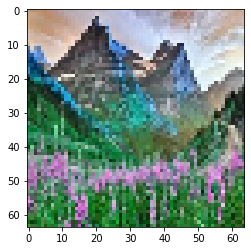

In [106]:
# img = plt.imread('tr.jpeg')
# ar = img.reshape(28,28)
# torch.tensor(img)
x = valid_dataset[25][0]
print(x.shape)
x= x.permute(1,2,0)

plt.imshow(x)
# train_dataset[0][0].numpy().shape
classes

In [107]:
def plot_loss(loss):
        '''
        Plots the loss curve
        '''
        fig = plt.figure(figsize=(10,10))
        plt.plot(loss)
        plt.xlabel("Iteration")
        plt.ylabel("logloss")
        plt.title("Loss curve for training")
        plt.show() 

In [108]:
train_loader = DataLoader2(train_dataset,batch_size=batch_size,shuffle=True) 
test_loader = DataLoader2(test_dataset,batch_size=batch_size,shuffle=True) 
valid_loader = DataLoader2(valid_dataset,batch_size=batch_size,shuffle=True) 


In [109]:
def accuracy(train_loader,test_loader,valid_loader=None,model=None,reshape=True):
    train_acc_score, test_acc_score,valid_acc_score = 0.0,0.0,0.0
    model.eval()
    r_pred=[]
    r=[]
    for _,(x,y) in enumerate(train_loader):
        if reshape==True:
            x = x.reshape(x.shape[0],-1)
        scores = model(x)
        _, y_pred = scores.max(1)
        r = r + list(y.numpy())
        r_pred = r_pred + list(y_pred.numpy())
    
    print("\n\n########## Train Data Accuracy ######### \n\n")
    print(classification_report(r,r_pred))
    train_acc_score = accuracy_score(r,r_pred)
    sns.heatmap(confusion_matrix(r,r_pred))
    plt.show()
    
    
    
    r_pred=[]
    r=[]
    for _,(x,y) in enumerate(test_loader):
        if reshape==True:
            x = x.reshape(x.shape[0],-1)
        scores = model(x)
        _, y_pred = scores.max(1)
        r = r + list(y.numpy())
        r_pred = r_pred + list(y_pred.numpy())
    
    print("\n\n########## Test Data Accuracy ######### \n\n") 
    print(classification_report(r,r_pred))
    test_acc_score = accuracy_score(r,r_pred)
    
    sns.heatmap(confusion_matrix(r,r_pred))
    
    if valid_loader is not None:
        r_pred=[]
        r=[]
        for _,(x,y) in enumerate(valid_loader):
            if reshape==True:
                x = x.reshape(x.shape[0],-1)
            scores = model(x)
            _, y_pred = scores.max(1)
            r = r + list(y.numpy())
            r_pred = r_pred + list(y_pred.numpy())
    
        print("\n\n########## Valid Data Accuracy ######### \n\n") 
        print(classification_report(r,r_pred))
        valid_acc_score = accuracy_score(r,r_pred)
        sns.heatmap(confusion_matrix(r,r_pred))
        
    return train_acc_score, test_acc_score,valid_acc_score 


In [110]:
######### CNN Example
class CNN(nn.Module):
    def __init__(self,in_channels=1,num_classes=10):
        super(CNN,self).__init__()
        self.conv1 = nn.Conv2d(in_channels,16,kernel_size=(2,2),stride=(1,1),padding=(1,1))
        self.conv2 = nn.Conv2d(16,8,kernel_size=(2,2),stride=(1,1),padding=(1,1))
        self.conv3 = nn.Conv2d(8,8,kernel_size=(3,3),stride=(1,1),padding=(1,1))
        self.maxpool = nn.MaxPool2d(kernel_size=(2,2),stride=(2,2))
        self.fc1 = nn.Linear(8*16*16,32)        
        self.fc2 = nn.Linear(32,10)        
        self.fc3 = nn.Linear(10,num_classes)        
#         self.fc2 = nn.Linear(20,num_classes)pri
    def forward(self,x):
        x = x.type(dtype=torch.float32)
        x = F.relu(self.conv1(x))
        x = self.maxpool(x)
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = self.maxpool(x)
#         print(x.shape)

        x = x.reshape(x.shape[0],-1)
#         print(x.shape)
        
        x = F.relu(self.fc1(x))     
        x = F.relu(self.fc2(x))     
        x = self.fc3(x)   
#         x = self.fc2(x)       
#         x = self.fc2(x)
        return x

In [111]:
# x = torch.rand((128,3,64,64))
# model_cnn = CNN(in_channels,num_classes)
# scores = model_cnn(x)

In [112]:
in_channels= 3
num_classes= 5
lr = 0.01
epochs = 50

## Model Initialization
model_cnn = CNN(in_channels,num_classes)


## Loss Function and Optimizer
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_cnn.parameters(),lr=lr,weight_decay=0.001)
# scheduler = ReduceLROnPlateau(optimizer, 'min', patience = 5)
scheduler = ExponentialLR(optimizer, gamma=0.8)

##### Train The network ##########
# train_loss = []
models=[]
for epoch in range(epochs):
    
    ##train
    train_loss, valid_loss = 0.0, 0.0
    model_cnn.train()
    for batch_id,(x,y) in  tqdm(enumerate(train_loader)):
        
#         x = x.reshape(x.shape[0],-1)
        scores = model_cnn(x)
        loss = loss_func(scores,y)
        
        # backward prop
        optimizer.zero_grad()
        loss.backward()
        
        optimizer.step()
        train_loss += loss.item()
    
    ## validation
    model_cnn.eval()
    for batch_id,(x,y) in  tqdm(enumerate(valid_loader)):
  
        scores = model_cnn(x)
        loss = loss_func(scores, y)
  
        valid_loss += loss.item() 
    d = {'valid_loss': valid_loss/len(valid_loader) ,'model': copy.deepcopy(model_cnn),'train_loss': train_loss/len(train_loader)}
    models.append(d)
    curr_lr = optimizer.param_groups[0]['lr']
    print(f'Epoch {epoch+1}\t \
            Training Loss: {train_loss/len(train_loader)}\t \
            Validation Loss:{valid_loss/len(valid_loader)}\t \
            LR:{curr_lr}')
    if(epoch%6==0):
        scheduler.step(epoch)
    
    
    
    
#     print('epoch {}/{}  loss={} '.format(epochs, epoch+1,loss))
# plot_loss(train_loss)
    


        


79it [00:14,  5.55it/s]
12it [00:01,  8.59it/s]
/opt/homebrew/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:163: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 1	             Training Loss: 1.5710940949524506	             Validation Loss:1.4616944988568623	             LR:0.01


79it [00:12,  6.27it/s]
12it [00:01,  9.04it/s]


Epoch 2	             Training Loss: 1.2449428703211531	             Validation Loss:1.1587197184562683	             LR:0.01


79it [00:12,  6.09it/s]
12it [00:01, 10.59it/s]


Epoch 3	             Training Loss: 1.053732689422897	             Validation Loss:1.1052278280258179	             LR:0.01


79it [00:12,  6.24it/s]
12it [00:01, 10.57it/s]


Epoch 4	             Training Loss: 0.924205170402044	             Validation Loss:1.132834941148758	             LR:0.01


79it [00:13,  5.90it/s]
12it [00:01,  8.69it/s]


Epoch 5	             Training Loss: 0.8787142166608497	             Validation Loss:1.074368730187416	             LR:0.01


79it [00:13,  5.73it/s]
12it [00:01,  8.67it/s]


Epoch 6	             Training Loss: 0.8583959680569323	             Validation Loss:1.1275529116392136	             LR:0.01


79it [00:15,  5.23it/s]
12it [00:01,  8.54it/s]


Epoch 7	             Training Loss: 0.8634202352053002	             Validation Loss:1.011364261309306	             LR:0.01


79it [00:13,  5.88it/s]
12it [00:01,  8.68it/s]


Epoch 8	             Training Loss: 0.7553896058963824	             Validation Loss:0.9192958623170853	             LR:0.002621440000000001


79it [00:13,  6.01it/s]
12it [00:01,  8.68it/s]


Epoch 9	             Training Loss: 0.7035293258443663	             Validation Loss:0.9518062025308609	             LR:0.002621440000000001


79it [00:13,  5.84it/s]
12it [00:01,  8.69it/s]


Epoch 10	             Training Loss: 0.6808301183996321	             Validation Loss:0.9398134350776672	             LR:0.002621440000000001


79it [00:13,  5.86it/s]
12it [00:01,  8.58it/s]


Epoch 11	             Training Loss: 0.6673037805889226	             Validation Loss:0.9951024254163107	             LR:0.002621440000000001


79it [00:13,  5.86it/s]
12it [00:01,  8.51it/s]


Epoch 12	             Training Loss: 0.631398116485982	             Validation Loss:0.9812838584184647	             LR:0.002621440000000001


79it [00:13,  5.87it/s]
12it [00:01,  8.66it/s]


Epoch 13	             Training Loss: 0.5977650820454464	             Validation Loss:0.9996863603591919	             LR:0.002621440000000001


79it [00:13,  5.88it/s]
12it [00:01,  8.57it/s]


Epoch 14	             Training Loss: 0.5111019034174424	             Validation Loss:1.0817491014798482	             LR:0.0006871947673600004


79it [00:13,  5.91it/s]
12it [00:01,  8.69it/s]


Epoch 15	             Training Loss: 0.48185909209372124	             Validation Loss:1.0910570720831554	             LR:0.0006871947673600004


79it [00:13,  5.78it/s]
12it [00:01,  8.65it/s]


Epoch 16	             Training Loss: 0.461571722845488	             Validation Loss:1.1350923031568527	             LR:0.0006871947673600004


79it [00:13,  5.86it/s]
12it [00:01,  8.55it/s]


Epoch 17	             Training Loss: 0.4460443039483662	             Validation Loss:1.1736077070236206	             LR:0.0006871947673600004


79it [00:13,  5.84it/s]
12it [00:01,  8.66it/s]


Epoch 18	             Training Loss: 0.423300293804724	             Validation Loss:1.208416720231374	             LR:0.0006871947673600004


79it [00:13,  5.69it/s]
12it [00:01,  8.10it/s]


Epoch 19	             Training Loss: 0.40197972217692607	             Validation Loss:1.2466464539368947	             LR:0.0006871947673600004


79it [00:14,  5.30it/s]
12it [00:01,  8.57it/s]


Epoch 20	             Training Loss: 0.3678131782555882	             Validation Loss:1.2773071080446243	             LR:0.00018014398509482002


79it [00:13,  5.66it/s]
12it [00:01, 10.15it/s]


Epoch 21	             Training Loss: 0.3592948887167098	             Validation Loss:1.309350699186325	             LR:0.00018014398509482002


79it [00:12,  6.38it/s]
12it [00:01, 10.34it/s]


Epoch 22	             Training Loss: 0.3541533828158922	             Validation Loss:1.3105889062086742	             LR:0.00018014398509482002


79it [00:12,  6.37it/s]
12it [00:01, 10.35it/s]


Epoch 23	             Training Loss: 0.3465098936723757	             Validation Loss:1.3310969471931458	             LR:0.00018014398509482002


79it [00:12,  6.38it/s]
12it [00:01, 10.32it/s]


Epoch 24	             Training Loss: 0.33981240701071824	             Validation Loss:1.347380707661311	             LR:0.00018014398509482002


79it [00:12,  6.37it/s]
12it [00:01, 10.33it/s]


Epoch 25	             Training Loss: 0.33421326117425026	             Validation Loss:1.3659931421279907	             LR:0.00018014398509482002


79it [00:12,  6.34it/s]
12it [00:01, 10.30it/s]


Epoch 26	             Training Loss: 0.3303385763605939	             Validation Loss:1.3732089499632518	             LR:4.722366482869652e-05


79it [00:12,  6.37it/s]
12it [00:01, 10.30it/s]


Epoch 27	             Training Loss: 0.323674811026718	             Validation Loss:1.3686639765898387	             LR:4.722366482869652e-05


79it [00:12,  6.15it/s]
12it [00:01,  7.99it/s]


Epoch 28	             Training Loss: 0.3222853911073902	             Validation Loss:1.3931919535001118	             LR:4.722366482869652e-05


79it [00:13,  5.73it/s]
12it [00:01, 10.36it/s]


Epoch 29	             Training Loss: 0.3215746872032745	             Validation Loss:1.4040311723947525	             LR:4.722366482869652e-05


79it [00:12,  6.39it/s]
12it [00:01, 10.34it/s]


Epoch 30	             Training Loss: 0.3199066749856442	             Validation Loss:1.3935937384764354	             LR:4.722366482869652e-05


79it [00:12,  6.12it/s]
12it [00:01, 10.31it/s]


Epoch 31	             Training Loss: 0.32386302136922185	             Validation Loss:1.40211221575737	             LR:4.722366482869652e-05


79it [00:12,  6.37it/s]
12it [00:01, 10.28it/s]


Epoch 32	             Training Loss: 0.31759622504439533	             Validation Loss:1.3931984106699626	             LR:1.2379400392853824e-05


79it [00:12,  6.13it/s]
12it [00:01, 10.35it/s]


Epoch 33	             Training Loss: 0.31522406996050967	             Validation Loss:1.3944204449653625	             LR:1.2379400392853824e-05


79it [00:12,  6.35it/s]
12it [00:01, 10.38it/s]


Epoch 34	             Training Loss: 0.3146383854784543	             Validation Loss:1.4002191821734111	             LR:1.2379400392853824e-05


79it [00:13,  5.96it/s]
12it [00:01,  9.43it/s]


Epoch 35	             Training Loss: 0.3136943906922884	             Validation Loss:1.3946338295936584	             LR:1.2379400392853824e-05


79it [00:13,  6.01it/s]
12it [00:01,  8.48it/s]


Epoch 36	             Training Loss: 0.3122825451855418	             Validation Loss:1.4022431472937267	             LR:1.2379400392853824e-05


79it [00:14,  5.59it/s]
12it [00:01, 10.21it/s]


Epoch 37	             Training Loss: 0.31493754873547375	             Validation Loss:1.4124334057172139	             LR:1.2379400392853824e-05


79it [00:13,  5.77it/s]
12it [00:01,  8.90it/s]


Epoch 38	             Training Loss: 0.314207773985742	             Validation Loss:1.4030481576919556	             LR:3.2451855365842735e-06


79it [00:13,  6.03it/s]
12it [00:01,  8.66it/s]


Epoch 39	             Training Loss: 0.31496119084237495	             Validation Loss:1.4030358791351318	             LR:3.2451855365842735e-06


79it [00:13,  5.99it/s]
12it [00:01,  8.84it/s]


Epoch 40	             Training Loss: 0.31247861626782	             Validation Loss:1.407605618238449	             LR:3.2451855365842735e-06


79it [00:13,  6.02it/s]
12it [00:01,  8.67it/s]


Epoch 41	             Training Loss: 0.31335990206350256	             Validation Loss:1.4041782915592194	             LR:3.2451855365842735e-06


79it [00:13,  5.94it/s]
12it [00:01,  8.70it/s]


Epoch 42	             Training Loss: 0.3115857615123821	             Validation Loss:1.4177115956942241	             LR:3.2451855365842735e-06


79it [00:13,  5.78it/s]
12it [00:01,  8.60it/s]


Epoch 43	             Training Loss: 0.31664170758633675	             Validation Loss:1.4103772640228271	             LR:3.2451855365842735e-06


79it [00:13,  5.77it/s]
12it [00:01,  8.64it/s]


Epoch 44	             Training Loss: 0.3145397460158867	             Validation Loss:1.412406971057256	             LR:8.507059173023481e-07


79it [00:13,  5.86it/s]
12it [00:01,  8.67it/s]


Epoch 45	             Training Loss: 0.3129831471397907	             Validation Loss:1.3964711676041286	             LR:8.507059173023481e-07


79it [00:13,  5.86it/s]
12it [00:01,  8.65it/s]


Epoch 46	             Training Loss: 0.31287936639936664	             Validation Loss:1.4022547503312428	             LR:8.507059173023481e-07


79it [00:13,  5.77it/s]
12it [00:01,  8.66it/s]


Epoch 47	             Training Loss: 0.3134703649372994	             Validation Loss:1.410387545824051	             LR:8.507059173023481e-07


79it [00:13,  5.77it/s]
12it [00:01,  8.58it/s]


Epoch 48	             Training Loss: 0.3168393575315234	             Validation Loss:1.424793263276418	             LR:8.507059173023481e-07


79it [00:13,  5.70it/s]
12it [00:01,  8.60it/s]


Epoch 49	             Training Loss: 0.3129938365537909	             Validation Loss:1.4044977227846782	             LR:8.507059173023481e-07


79it [00:13,  5.76it/s]
12it [00:01,  8.68it/s]

Epoch 50	             Training Loss: 0.31152905580363693	             Validation Loss:1.4110785921414692	             LR:2.2300745198530684e-07


############# epoch 1 ############


########## Train Data Accuracy ######### 


              precision    recall  f1-score   support

           0       0.38      0.15      0.21      2000
           1       0.23      0.09      0.13      2000
           2       0.28      0.97      0.44      2000
           3       0.24      0.04      0.07      2000
           4       0.77      0.48      0.60      2000

    accuracy                           0.35     10000
   macro avg       0.38      0.35      0.29     10000
weighted avg       0.38      0.35      0.29     10000



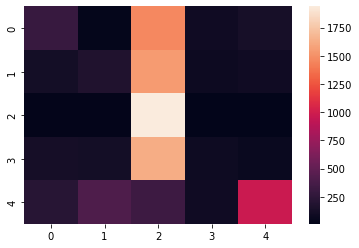



########## Test Data Accuracy ######### 


              precision    recall  f1-score   support

           0       0.56      0.18      0.27       100
           1       0.22      0.08      0.12       100
           2       0.29      0.98      0.45       100
           3       0.09      0.02      0.03       100
           4       0.87      0.61      0.72       100

    accuracy                           0.37       500
   macro avg       0.41      0.37      0.32       500
weighted avg       0.41      0.37      0.32       500



########## Valid Data Accuracy ######### 


              precision    recall  f1-score   support

           0       0.38      0.16      0.22       300
           1       0.26      0.08      0.12       300
           2       0.28      0.97      0.43       300
           3       0.10      0.02      0.04       300
           4       0.83      0.42      0.56       300

    accuracy                           0.33      1500
   macro avg       0.37      0.33      0

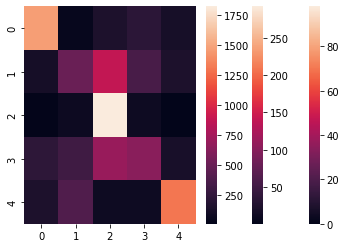



########## Test Data Accuracy ######### 


              precision    recall  f1-score   support

           0       0.82      0.76      0.79       100
           1       0.45      0.27      0.34       100
           2       0.45      0.94      0.61       100
           3       0.37      0.17      0.23       100
           4       0.83      0.78      0.80       100

    accuracy                           0.58       500
   macro avg       0.58      0.58      0.55       500
weighted avg       0.58      0.58      0.55       500



########## Valid Data Accuracy ######### 


              precision    recall  f1-score   support

           0       0.75      0.74      0.74       300
           1       0.39      0.23      0.29       300
           2       0.43      0.84      0.57       300
           3       0.36      0.24      0.29       300
           4       0.80      0.63      0.70       300

    accuracy                           0.54      1500
   macro avg       0.55      0.54      0

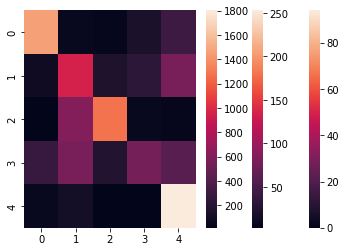



########## Test Data Accuracy ######### 


              precision    recall  f1-score   support

           0       0.86      0.81      0.84       100
           1       0.45      0.55      0.49       100
           2       0.69      0.68      0.69       100
           3       0.47      0.17      0.25       100
           4       0.66      0.98      0.79       100

    accuracy                           0.64       500
   macro avg       0.63      0.64      0.61       500
weighted avg       0.63      0.64      0.61       500



########## Valid Data Accuracy ######### 


              precision    recall  f1-score   support

           0       0.81      0.73      0.77       300
           1       0.33      0.45      0.38       300
           2       0.64      0.50      0.56       300
           3       0.36      0.16      0.22       300
           4       0.59      0.90      0.71       300

    accuracy                           0.55      1500
   macro avg       0.55      0.55      0

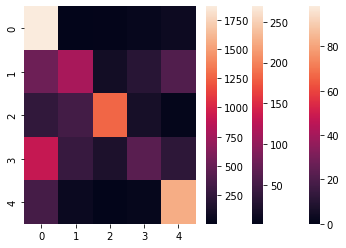



########## Test Data Accuracy ######### 


              precision    recall  f1-score   support

           0       0.49      0.91      0.64       100
           1       0.58      0.45      0.51       100
           2       0.72      0.66      0.69       100
           3       0.39      0.11      0.17       100
           4       0.76      0.90      0.83       100

    accuracy                           0.61       500
   macro avg       0.59      0.61      0.57       500
weighted avg       0.59      0.61      0.57       500



########## Valid Data Accuracy ######### 


              precision    recall  f1-score   support

           0       0.45      0.90      0.60       300
           1       0.45      0.42      0.43       300
           2       0.71      0.52      0.60       300
           3       0.50      0.20      0.28       300
           4       0.66      0.62      0.64       300

    accuracy                           0.53      1500
   macro avg       0.56      0.53      0

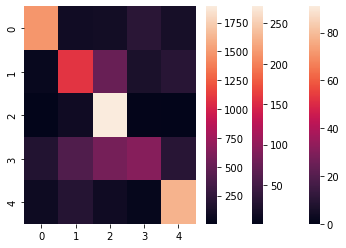



########## Test Data Accuracy ######### 


              precision    recall  f1-score   support

           0       0.90      0.77      0.83       100
           1       0.66      0.52      0.58       100
           2       0.52      0.94      0.67       100
           3       0.45      0.17      0.25       100
           4       0.80      0.92      0.86       100

    accuracy                           0.66       500
   macro avg       0.66      0.66      0.64       500
weighted avg       0.66      0.66      0.64       500



########## Valid Data Accuracy ######### 


              precision    recall  f1-score   support

           0       0.82      0.75      0.78       300
           1       0.51      0.49      0.50       300
           2       0.51      0.87      0.65       300
           3       0.35      0.17      0.23       300
           4       0.75      0.71      0.73       300

    accuracy                           0.60      1500
   macro avg       0.59      0.60      0

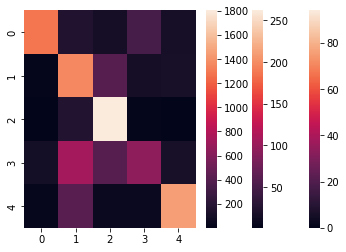



########## Test Data Accuracy ######### 


              precision    recall  f1-score   support

           0       0.95      0.69      0.80       100
           1       0.51      0.66      0.57       100
           2       0.58      0.91      0.71       100
           3       0.39      0.16      0.23       100
           4       0.81      0.81      0.81       100

    accuracy                           0.65       500
   macro avg       0.65      0.65      0.62       500
weighted avg       0.65      0.65      0.62       500



########## Valid Data Accuracy ######### 


              precision    recall  f1-score   support

           0       0.93      0.63      0.75       300
           1       0.42      0.62      0.51       300
           2       0.54      0.85      0.66       300
           3       0.30      0.13      0.18       300
           4       0.83      0.70      0.76       300

    accuracy                           0.59      1500
   macro avg       0.60      0.59      0

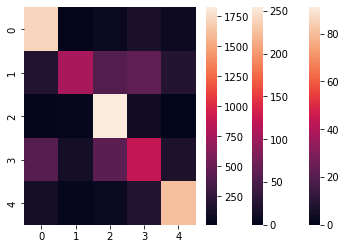



########## Test Data Accuracy ######### 


              precision    recall  f1-score   support

           0       0.76      0.85      0.80       100
           1       0.72      0.29      0.41       100
           2       0.52      0.89      0.65       100
           3       0.38      0.27      0.31       100
           4       0.85      0.88      0.86       100

    accuracy                           0.64       500
   macro avg       0.64      0.64      0.61       500
weighted avg       0.64      0.64      0.61       500



########## Valid Data Accuracy ######### 


              precision    recall  f1-score   support

           0       0.71      0.84      0.77       300
           1       0.68      0.35      0.46       300
           2       0.54      0.79      0.64       300
           3       0.41      0.38      0.39       300
           4       0.82      0.74      0.78       300

    accuracy                           0.62      1500
   macro avg       0.63      0.62      0

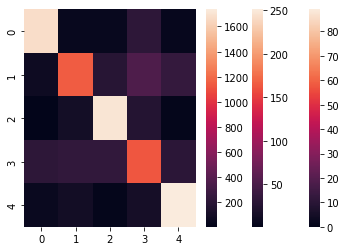



########## Test Data Accuracy ######### 


              precision    recall  f1-score   support

           0       0.84      0.83      0.83       100
           1       0.63      0.50      0.56       100
           2       0.66      0.86      0.75       100
           3       0.40      0.31      0.35       100
           4       0.79      0.91      0.85       100

    accuracy                           0.68       500
   macro avg       0.67      0.68      0.67       500
weighted avg       0.67      0.68      0.67       500



########## Valid Data Accuracy ######### 


              precision    recall  f1-score   support

           0       0.83      0.79      0.81       300
           1       0.54      0.49      0.51       300
           2       0.63      0.75      0.68       300
           3       0.41      0.37      0.39       300
           4       0.76      0.81      0.79       300

    accuracy                           0.64      1500
   macro avg       0.63      0.64      0

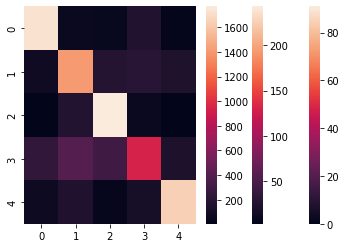



########## Test Data Accuracy ######### 


              precision    recall  f1-score   support

           0       0.84      0.84      0.84       100
           1       0.63      0.69      0.66       100
           2       0.66      0.90      0.76       100
           3       0.42      0.22      0.29       100
           4       0.82      0.84      0.83       100

    accuracy                           0.70       500
   macro avg       0.68      0.70      0.68       500
weighted avg       0.68      0.70      0.68       500



########## Valid Data Accuracy ######### 


              precision    recall  f1-score   support

           0       0.80      0.79      0.80       300
           1       0.51      0.60      0.55       300
           2       0.62      0.76      0.69       300
           3       0.43      0.30      0.36       300
           4       0.81      0.74      0.78       300

    accuracy                           0.64      1500
   macro avg       0.64      0.64      0

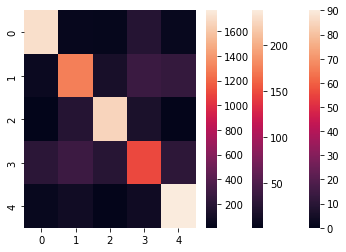



########## Test Data Accuracy ######### 


              precision    recall  f1-score   support

           0       0.85      0.82      0.83       100
           1       0.63      0.59      0.61       100
           2       0.71      0.85      0.78       100
           3       0.46      0.33      0.39       100
           4       0.78      0.93      0.85       100

    accuracy                           0.70       500
   macro avg       0.69      0.70      0.69       500
weighted avg       0.69      0.70      0.69       500



########## Valid Data Accuracy ######### 


              precision    recall  f1-score   support

           0       0.84      0.79      0.81       300
           1       0.52      0.54      0.53       300
           2       0.65      0.71      0.68       300
           3       0.46      0.36      0.40       300
           4       0.74      0.84      0.79       300

    accuracy                           0.65      1500
   macro avg       0.64      0.65      0

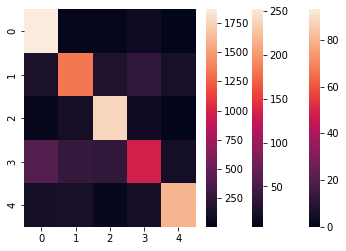



########## Test Data Accuracy ######### 


              precision    recall  f1-score   support

           0       0.72      0.89      0.79       100
           1       0.66      0.61      0.64       100
           2       0.66      0.90      0.76       100
           3       0.40      0.22      0.28       100
           4       0.87      0.81      0.84       100

    accuracy                           0.69       500
   macro avg       0.66      0.69      0.66       500
weighted avg       0.66      0.69      0.66       500



########## Valid Data Accuracy ######### 


              precision    recall  f1-score   support

           0       0.72      0.87      0.79       300
           1       0.53      0.54      0.53       300
           2       0.63      0.75      0.68       300
           3       0.47      0.35      0.40       300
           4       0.85      0.70      0.77       300

    accuracy                           0.64      1500
   macro avg       0.64      0.64      0

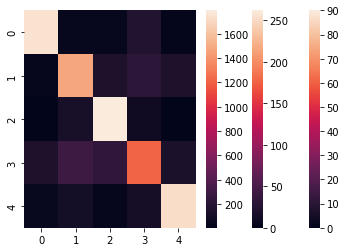



########## Test Data Accuracy ######### 


              precision    recall  f1-score   support

           0       0.85      0.83      0.84       100
           1       0.64      0.58      0.61       100
           2       0.67      0.90      0.77       100
           3       0.47      0.34      0.40       100
           4       0.83      0.86      0.84       100

    accuracy                           0.70       500
   macro avg       0.69      0.70      0.69       500
weighted avg       0.69      0.70      0.69       500



########## Valid Data Accuracy ######### 


              precision    recall  f1-score   support

           0       0.84      0.78      0.81       300
           1       0.52      0.55      0.53       300
           2       0.63      0.76      0.68       300
           3       0.44      0.37      0.40       300
           4       0.80      0.75      0.78       300

    accuracy                           0.64      1500
   macro avg       0.64      0.64      0

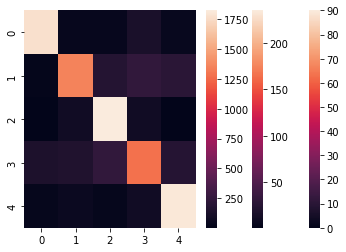



########## Test Data Accuracy ######### 


              precision    recall  f1-score   support

           0       0.85      0.84      0.84       100
           1       0.69      0.50      0.58       100
           2       0.67      0.92      0.78       100
           3       0.55      0.39      0.46       100
           4       0.74      0.89      0.81       100

    accuracy                           0.71       500
   macro avg       0.70      0.71      0.69       500
weighted avg       0.70      0.71      0.69       500



########## Valid Data Accuracy ######### 


              precision    recall  f1-score   support

           0       0.83      0.80      0.82       300
           1       0.55      0.50      0.52       300
           2       0.61      0.75      0.67       300
           3       0.46      0.37      0.41       300
           4       0.76      0.83      0.79       300

    accuracy                           0.65      1500
   macro avg       0.64      0.65      0

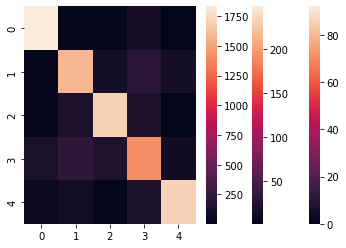



########## Test Data Accuracy ######### 


              precision    recall  f1-score   support

           0       0.80      0.83      0.81       100
           1       0.66      0.61      0.64       100
           2       0.68      0.84      0.75       100
           3       0.45      0.39      0.42       100
           4       0.84      0.80      0.82       100

    accuracy                           0.69       500
   macro avg       0.69      0.69      0.69       500
weighted avg       0.69      0.69      0.69       500



########## Valid Data Accuracy ######### 


              precision    recall  f1-score   support

           0       0.78      0.79      0.79       300
           1       0.48      0.55      0.52       300
           2       0.69      0.68      0.68       300
           3       0.42      0.41      0.42       300
           4       0.82      0.72      0.77       300

    accuracy                           0.63      1500
   macro avg       0.64      0.63      0

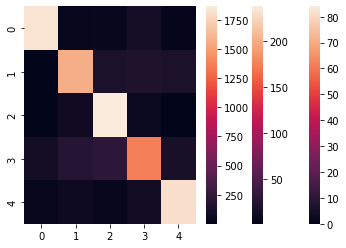



########## Test Data Accuracy ######### 


              precision    recall  f1-score   support

           0       0.84      0.83      0.83       100
           1       0.71      0.55      0.62       100
           2       0.68      0.92      0.78       100
           3       0.48      0.38      0.42       100
           4       0.79      0.85      0.82       100

    accuracy                           0.71       500
   macro avg       0.70      0.71      0.69       500
weighted avg       0.70      0.71      0.69       500



########## Valid Data Accuracy ######### 


              precision    recall  f1-score   support

           0       0.81      0.78      0.79       300
           1       0.52      0.53      0.52       300
           2       0.64      0.77      0.69       300
           3       0.44      0.37      0.40       300
           4       0.79      0.78      0.78       300

    accuracy                           0.64      1500
   macro avg       0.64      0.64      0

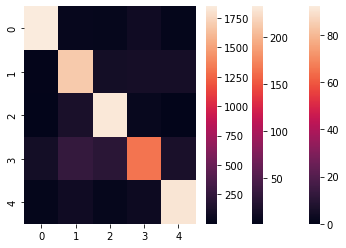



########## Test Data Accuracy ######### 


              precision    recall  f1-score   support

           0       0.84      0.81      0.82       100
           1       0.68      0.63      0.65       100
           2       0.70      0.92      0.80       100
           3       0.52      0.38      0.44       100
           4       0.81      0.86      0.83       100

    accuracy                           0.72       500
   macro avg       0.71      0.72      0.71       500
weighted avg       0.71      0.72      0.71       500



########## Valid Data Accuracy ######### 


              precision    recall  f1-score   support

           0       0.81      0.78      0.79       300
           1       0.49      0.60      0.54       300
           2       0.65      0.74      0.69       300
           3       0.44      0.32      0.37       300
           4       0.79      0.76      0.77       300

    accuracy                           0.64      1500
   macro avg       0.64      0.64      0

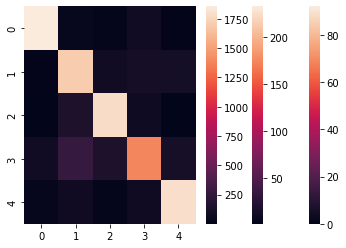



########## Test Data Accuracy ######### 


              precision    recall  f1-score   support

           0       0.81      0.83      0.82       100
           1       0.64      0.61      0.62       100
           2       0.70      0.85      0.77       100
           3       0.49      0.39      0.44       100
           4       0.82      0.84      0.83       100

    accuracy                           0.70       500
   macro avg       0.69      0.70      0.70       500
weighted avg       0.69      0.70      0.70       500



########## Valid Data Accuracy ######### 


              precision    recall  f1-score   support

           0       0.79      0.79      0.79       300
           1       0.50      0.60      0.54       300
           2       0.67      0.72      0.69       300
           3       0.43      0.34      0.38       300
           4       0.80      0.74      0.77       300

    accuracy                           0.64      1500
   macro avg       0.64      0.64      0

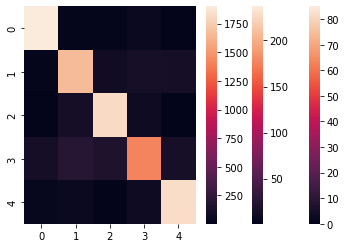



########## Test Data Accuracy ######### 


              precision    recall  f1-score   support

           0       0.78      0.83      0.81       100
           1       0.68      0.57      0.62       100
           2       0.69      0.87      0.77       100
           3       0.51      0.40      0.45       100
           4       0.81      0.85      0.83       100

    accuracy                           0.70       500
   macro avg       0.69      0.70      0.69       500
weighted avg       0.69      0.70      0.69       500



########## Valid Data Accuracy ######### 


              precision    recall  f1-score   support

           0       0.77      0.80      0.79       300
           1       0.50      0.55      0.52       300
           2       0.67      0.71      0.69       300
           3       0.44      0.36      0.39       300
           4       0.76      0.75      0.76       300

    accuracy                           0.63      1500
   macro avg       0.63      0.63      0

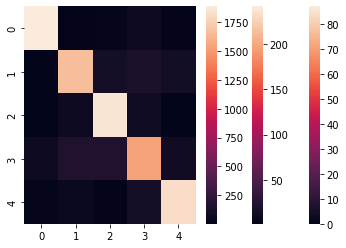



########## Test Data Accuracy ######### 


              precision    recall  f1-score   support

           0       0.80      0.81      0.81       100
           1       0.69      0.54      0.61       100
           2       0.69      0.90      0.78       100
           3       0.48      0.44      0.46       100
           4       0.82      0.81      0.81       100

    accuracy                           0.70       500
   macro avg       0.70      0.70      0.69       500
weighted avg       0.70      0.70      0.69       500



########## Valid Data Accuracy ######### 


              precision    recall  f1-score   support

           0       0.80      0.79      0.79       300
           1       0.51      0.53      0.52       300
           2       0.64      0.72      0.68       300
           3       0.42      0.39      0.41       300
           4       0.79      0.73      0.76       300

    accuracy                           0.63      1500
   macro avg       0.63      0.63      0

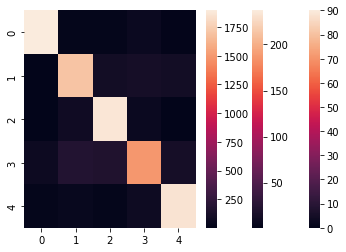



########## Test Data Accuracy ######### 


              precision    recall  f1-score   support

           0       0.81      0.82      0.82       100
           1       0.67      0.56      0.61       100
           2       0.68      0.90      0.78       100
           3       0.51      0.41      0.45       100
           4       0.82      0.84      0.83       100

    accuracy                           0.71       500
   macro avg       0.70      0.71      0.70       500
weighted avg       0.70      0.71      0.70       500



########## Valid Data Accuracy ######### 


              precision    recall  f1-score   support

           0       0.81      0.79      0.80       300
           1       0.49      0.54      0.51       300
           2       0.65      0.73      0.69       300
           3       0.42      0.36      0.39       300
           4       0.78      0.75      0.76       300

    accuracy                           0.63      1500
   macro avg       0.63      0.63      0

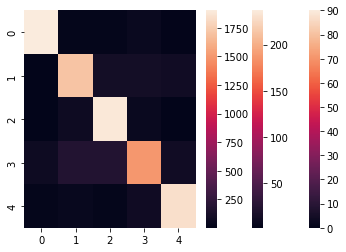



########## Test Data Accuracy ######### 


              precision    recall  f1-score   support

           0       0.80      0.81      0.81       100
           1       0.69      0.57      0.62       100
           2       0.68      0.90      0.78       100
           3       0.51      0.42      0.46       100
           4       0.81      0.83      0.82       100

    accuracy                           0.71       500
   macro avg       0.70      0.71      0.70       500
weighted avg       0.70      0.71      0.70       500



########## Valid Data Accuracy ######### 


              precision    recall  f1-score   support

           0       0.80      0.79      0.79       300
           1       0.49      0.53      0.51       300
           2       0.65      0.74      0.69       300
           3       0.42      0.37      0.39       300
           4       0.79      0.73      0.76       300

    accuracy                           0.63      1500
   macro avg       0.63      0.63      0

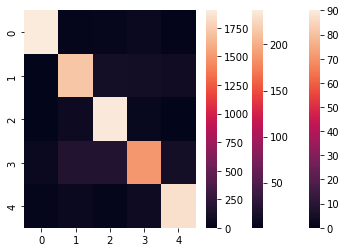



########## Test Data Accuracy ######### 


              precision    recall  f1-score   support

           0       0.81      0.82      0.82       100
           1       0.70      0.57      0.63       100
           2       0.68      0.90      0.78       100
           3       0.53      0.43      0.48       100
           4       0.81      0.84      0.82       100

    accuracy                           0.71       500
   macro avg       0.71      0.71      0.70       500
weighted avg       0.71      0.71      0.70       500



########## Valid Data Accuracy ######### 


              precision    recall  f1-score   support

           0       0.80      0.79      0.80       300
           1       0.50      0.54      0.52       300
           2       0.65      0.74      0.69       300
           3       0.43      0.37      0.40       300
           4       0.79      0.73      0.76       300

    accuracy                           0.63      1500
   macro avg       0.63      0.63      0

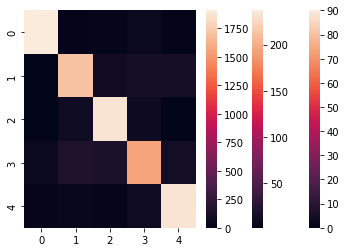



########## Test Data Accuracy ######### 


              precision    recall  f1-score   support

           0       0.81      0.82      0.82       100
           1       0.69      0.57      0.62       100
           2       0.69      0.87      0.77       100
           3       0.52      0.45      0.48       100
           4       0.82      0.84      0.83       100

    accuracy                           0.71       500
   macro avg       0.70      0.71      0.70       500
weighted avg       0.70      0.71      0.70       500



########## Valid Data Accuracy ######### 


              precision    recall  f1-score   support

           0       0.80      0.79      0.79       300
           1       0.50      0.53      0.51       300
           2       0.65      0.71      0.68       300
           3       0.42      0.38      0.40       300
           4       0.79      0.75      0.77       300

    accuracy                           0.63      1500
   macro avg       0.63      0.63      0

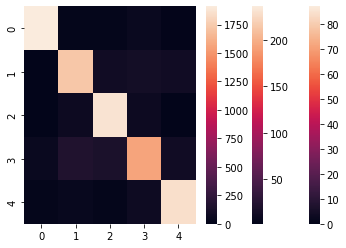



########## Test Data Accuracy ######### 


              precision    recall  f1-score   support

           0       0.81      0.82      0.82       100
           1       0.69      0.56      0.62       100
           2       0.68      0.88      0.77       100
           3       0.49      0.43      0.46       100
           4       0.82      0.84      0.83       100

    accuracy                           0.71       500
   macro avg       0.70      0.71      0.70       500
weighted avg       0.70      0.71      0.70       500



########## Valid Data Accuracy ######### 


              precision    recall  f1-score   support

           0       0.79      0.79      0.79       300
           1       0.49      0.53      0.51       300
           2       0.66      0.71      0.68       300
           3       0.41      0.38      0.39       300
           4       0.79      0.73      0.76       300

    accuracy                           0.63      1500
   macro avg       0.63      0.63      0

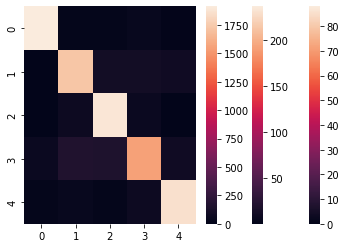



########## Test Data Accuracy ######### 


              precision    recall  f1-score   support

           0       0.80      0.80      0.80       100
           1       0.70      0.58      0.63       100
           2       0.68      0.90      0.78       100
           3       0.51      0.42      0.46       100
           4       0.81      0.83      0.82       100

    accuracy                           0.71       500
   macro avg       0.70      0.71      0.70       500
weighted avg       0.70      0.71      0.70       500



########## Valid Data Accuracy ######### 


              precision    recall  f1-score   support

           0       0.80      0.80      0.80       300
           1       0.49      0.55      0.52       300
           2       0.65      0.73      0.69       300
           3       0.43      0.37      0.40       300
           4       0.79      0.73      0.76       300

    accuracy                           0.64      1500
   macro avg       0.63      0.64      0

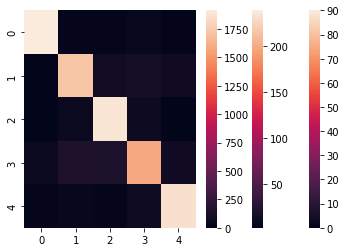



########## Test Data Accuracy ######### 


              precision    recall  f1-score   support

           0       0.79      0.80      0.80       100
           1       0.71      0.56      0.63       100
           2       0.68      0.88      0.77       100
           3       0.49      0.43      0.46       100
           4       0.81      0.83      0.82       100

    accuracy                           0.70       500
   macro avg       0.70      0.70      0.69       500
weighted avg       0.70      0.70      0.69       500



########## Valid Data Accuracy ######### 


              precision    recall  f1-score   support

           0       0.80      0.79      0.79       300
           1       0.48      0.53      0.51       300
           2       0.65      0.71      0.68       300
           3       0.41      0.37      0.39       300
           4       0.78      0.72      0.75       300

    accuracy                           0.63      1500
   macro avg       0.63      0.63      0

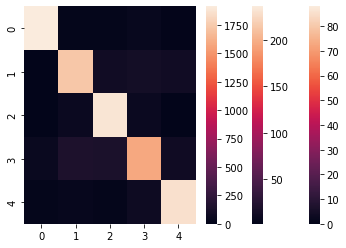



########## Test Data Accuracy ######### 


              precision    recall  f1-score   support

           0       0.80      0.80      0.80       100
           1       0.71      0.56      0.63       100
           2       0.68      0.89      0.77       100
           3       0.49      0.43      0.46       100
           4       0.81      0.83      0.82       100

    accuracy                           0.70       500
   macro avg       0.70      0.70      0.69       500
weighted avg       0.70      0.70      0.69       500



########## Valid Data Accuracy ######### 


              precision    recall  f1-score   support

           0       0.80      0.79      0.79       300
           1       0.49      0.53      0.51       300
           2       0.65      0.71      0.68       300
           3       0.41      0.38      0.39       300
           4       0.78      0.72      0.75       300

    accuracy                           0.62      1500
   macro avg       0.63      0.62      0

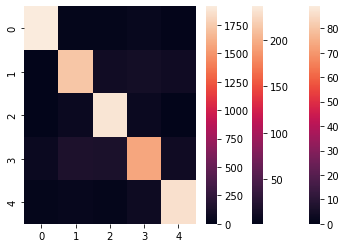



########## Test Data Accuracy ######### 


              precision    recall  f1-score   support

           0       0.79      0.81      0.80       100
           1       0.71      0.57      0.63       100
           2       0.68      0.88      0.77       100
           3       0.51      0.43      0.46       100
           4       0.81      0.83      0.82       100

    accuracy                           0.70       500
   macro avg       0.70      0.70      0.70       500
weighted avg       0.70      0.70      0.70       500



########## Valid Data Accuracy ######### 


              precision    recall  f1-score   support

           0       0.80      0.79      0.79       300
           1       0.49      0.53      0.51       300
           2       0.65      0.71      0.68       300
           3       0.42      0.38      0.40       300
           4       0.78      0.73      0.75       300

    accuracy                           0.63      1500
   macro avg       0.63      0.63      0

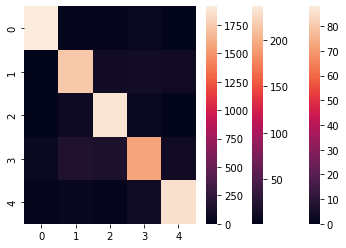



########## Test Data Accuracy ######### 


              precision    recall  f1-score   support

           0       0.80      0.80      0.80       100
           1       0.70      0.58      0.63       100
           2       0.68      0.89      0.77       100
           3       0.50      0.42      0.46       100
           4       0.81      0.83      0.82       100

    accuracy                           0.70       500
   macro avg       0.70      0.70      0.70       500
weighted avg       0.70      0.70      0.70       500



########## Valid Data Accuracy ######### 


              precision    recall  f1-score   support

           0       0.80      0.79      0.79       300
           1       0.48      0.53      0.51       300
           2       0.65      0.71      0.68       300
           3       0.42      0.38      0.40       300
           4       0.79      0.72      0.75       300

    accuracy                           0.63      1500
   macro avg       0.63      0.63      0

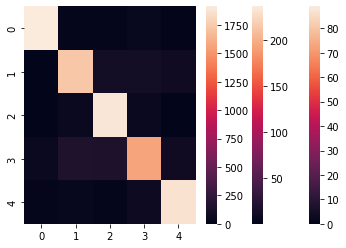



########## Test Data Accuracy ######### 


              precision    recall  f1-score   support

           0       0.80      0.80      0.80       100
           1       0.70      0.58      0.63       100
           2       0.68      0.89      0.77       100
           3       0.49      0.41      0.45       100
           4       0.81      0.83      0.82       100

    accuracy                           0.70       500
   macro avg       0.70      0.70      0.69       500
weighted avg       0.70      0.70      0.69       500



########## Valid Data Accuracy ######### 


              precision    recall  f1-score   support

           0       0.80      0.79      0.79       300
           1       0.49      0.53      0.51       300
           2       0.65      0.72      0.68       300
           3       0.42      0.37      0.39       300
           4       0.78      0.72      0.75       300

    accuracy                           0.63      1500
   macro avg       0.63      0.63      0

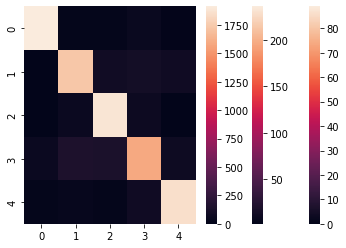



########## Test Data Accuracy ######### 


              precision    recall  f1-score   support

           0       0.79      0.80      0.80       100
           1       0.71      0.56      0.63       100
           2       0.68      0.88      0.77       100
           3       0.49      0.43      0.46       100
           4       0.81      0.83      0.82       100

    accuracy                           0.70       500
   macro avg       0.70      0.70      0.69       500
weighted avg       0.70      0.70      0.69       500



########## Valid Data Accuracy ######### 


              precision    recall  f1-score   support

           0       0.80      0.79      0.79       300
           1       0.48      0.52      0.50       300
           2       0.66      0.71      0.69       300
           3       0.41      0.38      0.39       300
           4       0.79      0.72      0.75       300

    accuracy                           0.63      1500
   macro avg       0.63      0.63      0

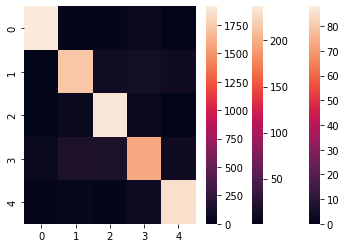



########## Test Data Accuracy ######### 


              precision    recall  f1-score   support

           0       0.79      0.80      0.80       100
           1       0.70      0.57      0.63       100
           2       0.68      0.88      0.77       100
           3       0.51      0.43      0.46       100
           4       0.81      0.83      0.82       100

    accuracy                           0.70       500
   macro avg       0.70      0.70      0.69       500
weighted avg       0.70      0.70      0.69       500



########## Valid Data Accuracy ######### 


              precision    recall  f1-score   support

           0       0.80      0.79      0.79       300
           1       0.49      0.53      0.51       300
           2       0.65      0.71      0.68       300
           3       0.41      0.38      0.40       300
           4       0.78      0.72      0.75       300

    accuracy                           0.63      1500
   macro avg       0.63      0.63      0

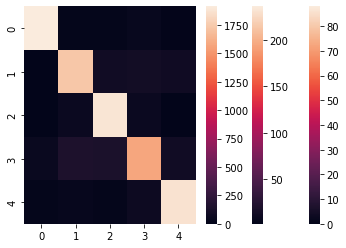



########## Test Data Accuracy ######### 


              precision    recall  f1-score   support

           0       0.79      0.80      0.80       100
           1       0.70      0.57      0.63       100
           2       0.68      0.88      0.77       100
           3       0.51      0.43      0.46       100
           4       0.81      0.83      0.82       100

    accuracy                           0.70       500
   macro avg       0.70      0.70      0.69       500
weighted avg       0.70      0.70      0.69       500



########## Valid Data Accuracy ######### 


              precision    recall  f1-score   support

           0       0.80      0.79      0.79       300
           1       0.49      0.53      0.51       300
           2       0.65      0.71      0.68       300
           3       0.41      0.38      0.39       300
           4       0.78      0.72      0.75       300

    accuracy                           0.62      1500
   macro avg       0.63      0.62      0

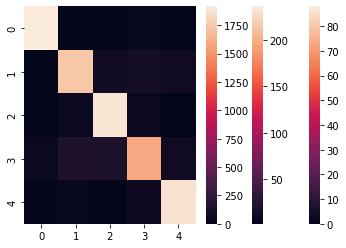



########## Test Data Accuracy ######### 


              precision    recall  f1-score   support

           0       0.79      0.80      0.80       100
           1       0.70      0.57      0.63       100
           2       0.68      0.88      0.77       100
           3       0.51      0.43      0.46       100
           4       0.81      0.83      0.82       100

    accuracy                           0.70       500
   macro avg       0.70      0.70      0.69       500
weighted avg       0.70      0.70      0.69       500



########## Valid Data Accuracy ######### 


              precision    recall  f1-score   support

           0       0.80      0.79      0.80       300
           1       0.49      0.53      0.51       300
           2       0.66      0.71      0.68       300
           3       0.41      0.38      0.40       300
           4       0.78      0.72      0.75       300

    accuracy                           0.63      1500
   macro avg       0.63      0.63      0

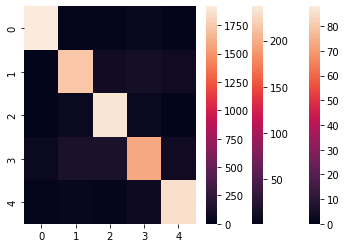



########## Test Data Accuracy ######### 


              precision    recall  f1-score   support

           0       0.79      0.80      0.80       100
           1       0.71      0.57      0.63       100
           2       0.68      0.88      0.77       100
           3       0.50      0.43      0.46       100
           4       0.81      0.83      0.82       100

    accuracy                           0.70       500
   macro avg       0.70      0.70      0.69       500
weighted avg       0.70      0.70      0.69       500



########## Valid Data Accuracy ######### 


              precision    recall  f1-score   support

           0       0.80      0.79      0.79       300
           1       0.49      0.53      0.51       300
           2       0.65      0.71      0.68       300
           3       0.41      0.38      0.40       300
           4       0.78      0.72      0.75       300

    accuracy                           0.63      1500
   macro avg       0.63      0.63      0

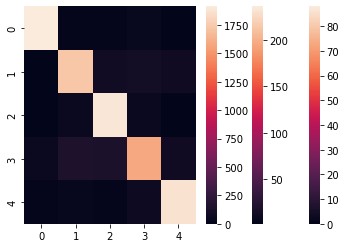



########## Test Data Accuracy ######### 


              precision    recall  f1-score   support

           0       0.79      0.80      0.80       100
           1       0.71      0.57      0.63       100
           2       0.68      0.88      0.77       100
           3       0.50      0.43      0.46       100
           4       0.81      0.83      0.82       100

    accuracy                           0.70       500
   macro avg       0.70      0.70      0.69       500
weighted avg       0.70      0.70      0.69       500



########## Valid Data Accuracy ######### 


              precision    recall  f1-score   support

           0       0.80      0.79      0.79       300
           1       0.49      0.53      0.51       300
           2       0.65      0.71      0.68       300
           3       0.42      0.38      0.40       300
           4       0.78      0.72      0.75       300

    accuracy                           0.63      1500
   macro avg       0.63      0.63      0

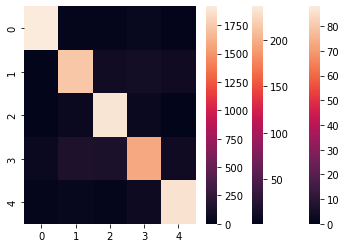



########## Test Data Accuracy ######### 


              precision    recall  f1-score   support

           0       0.79      0.80      0.80       100
           1       0.71      0.57      0.63       100
           2       0.68      0.88      0.77       100
           3       0.50      0.43      0.46       100
           4       0.81      0.83      0.82       100

    accuracy                           0.70       500
   macro avg       0.70      0.70      0.69       500
weighted avg       0.70      0.70      0.69       500



########## Valid Data Accuracy ######### 


              precision    recall  f1-score   support

           0       0.80      0.79      0.79       300
           1       0.49      0.53      0.51       300
           2       0.65      0.71      0.68       300
           3       0.41      0.38      0.40       300
           4       0.78      0.72      0.75       300

    accuracy                           0.62      1500
   macro avg       0.63      0.62      0

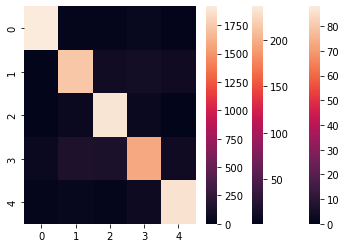



########## Test Data Accuracy ######### 


              precision    recall  f1-score   support

           0       0.79      0.80      0.80       100
           1       0.71      0.57      0.63       100
           2       0.68      0.88      0.77       100
           3       0.50      0.43      0.46       100
           4       0.81      0.83      0.82       100

    accuracy                           0.70       500
   macro avg       0.70      0.70      0.69       500
weighted avg       0.70      0.70      0.69       500



########## Valid Data Accuracy ######### 


              precision    recall  f1-score   support

           0       0.80      0.79      0.79       300
           1       0.49      0.53      0.51       300
           2       0.65      0.71      0.68       300
           3       0.41      0.38      0.40       300
           4       0.78      0.72      0.75       300

    accuracy                           0.63      1500
   macro avg       0.63      0.63      0

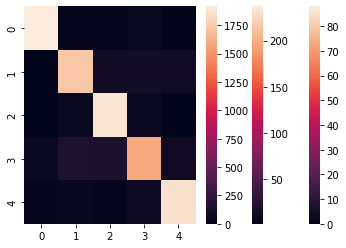



########## Test Data Accuracy ######### 


              precision    recall  f1-score   support

           0       0.79      0.80      0.80       100
           1       0.71      0.57      0.63       100
           2       0.68      0.88      0.77       100
           3       0.50      0.43      0.46       100
           4       0.81      0.83      0.82       100

    accuracy                           0.70       500
   macro avg       0.70      0.70      0.69       500
weighted avg       0.70      0.70      0.69       500



########## Valid Data Accuracy ######### 


              precision    recall  f1-score   support

           0       0.80      0.79      0.79       300
           1       0.49      0.53      0.51       300
           2       0.65      0.71      0.68       300
           3       0.41      0.38      0.40       300
           4       0.78      0.72      0.75       300

    accuracy                           0.62      1500
   macro avg       0.63      0.62      0

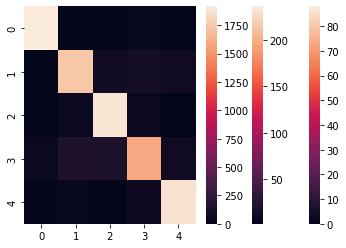



########## Test Data Accuracy ######### 


              precision    recall  f1-score   support

           0       0.79      0.80      0.80       100
           1       0.71      0.57      0.63       100
           2       0.68      0.88      0.77       100
           3       0.50      0.43      0.46       100
           4       0.81      0.83      0.82       100

    accuracy                           0.70       500
   macro avg       0.70      0.70      0.69       500
weighted avg       0.70      0.70      0.69       500



########## Valid Data Accuracy ######### 


              precision    recall  f1-score   support

           0       0.80      0.79      0.79       300
           1       0.49      0.53      0.51       300
           2       0.65      0.71      0.68       300
           3       0.41      0.38      0.40       300
           4       0.78      0.72      0.75       300

    accuracy                           0.63      1500
   macro avg       0.63      0.63      0

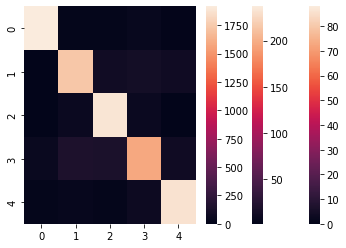



########## Test Data Accuracy ######### 


              precision    recall  f1-score   support

           0       0.79      0.80      0.80       100
           1       0.71      0.57      0.63       100
           2       0.68      0.88      0.77       100
           3       0.50      0.43      0.46       100
           4       0.81      0.83      0.82       100

    accuracy                           0.70       500
   macro avg       0.70      0.70      0.69       500
weighted avg       0.70      0.70      0.69       500



########## Valid Data Accuracy ######### 


              precision    recall  f1-score   support

           0       0.80      0.79      0.79       300
           1       0.49      0.53      0.51       300
           2       0.65      0.71      0.68       300
           3       0.41      0.38      0.40       300
           4       0.78      0.72      0.75       300

    accuracy                           0.63      1500
   macro avg       0.63      0.63      0

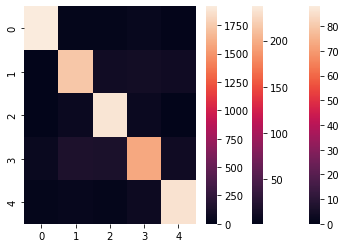



########## Test Data Accuracy ######### 


              precision    recall  f1-score   support

           0       0.79      0.80      0.80       100
           1       0.71      0.57      0.63       100
           2       0.68      0.88      0.77       100
           3       0.50      0.43      0.46       100
           4       0.81      0.83      0.82       100

    accuracy                           0.70       500
   macro avg       0.70      0.70      0.69       500
weighted avg       0.70      0.70      0.69       500



########## Valid Data Accuracy ######### 


              precision    recall  f1-score   support

           0       0.80      0.79      0.79       300
           1       0.49      0.53      0.51       300
           2       0.65      0.71      0.68       300
           3       0.41      0.38      0.40       300
           4       0.78      0.72      0.75       300

    accuracy                           0.63      1500
   macro avg       0.63      0.63      0

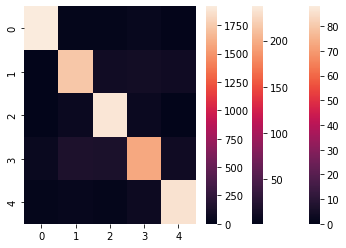



########## Test Data Accuracy ######### 


              precision    recall  f1-score   support

           0       0.79      0.80      0.80       100
           1       0.71      0.57      0.63       100
           2       0.68      0.88      0.77       100
           3       0.50      0.43      0.46       100
           4       0.81      0.83      0.82       100

    accuracy                           0.70       500
   macro avg       0.70      0.70      0.69       500
weighted avg       0.70      0.70      0.69       500



########## Valid Data Accuracy ######### 


              precision    recall  f1-score   support

           0       0.80      0.79      0.79       300
           1       0.49      0.53      0.51       300
           2       0.65      0.71      0.68       300
           3       0.41      0.38      0.40       300
           4       0.79      0.72      0.75       300

    accuracy                           0.63      1500
   macro avg       0.63      0.63      0

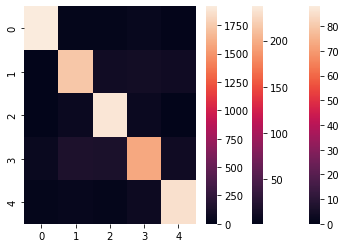



########## Test Data Accuracy ######### 


              precision    recall  f1-score   support

           0       0.79      0.80      0.80       100
           1       0.71      0.57      0.63       100
           2       0.68      0.88      0.77       100
           3       0.50      0.43      0.46       100
           4       0.81      0.83      0.82       100

    accuracy                           0.70       500
   macro avg       0.70      0.70      0.69       500
weighted avg       0.70      0.70      0.69       500



########## Valid Data Accuracy ######### 


              precision    recall  f1-score   support

           0       0.80      0.79      0.79       300
           1       0.49      0.53      0.51       300
           2       0.65      0.71      0.68       300
           3       0.41      0.38      0.40       300
           4       0.79      0.72      0.75       300

    accuracy                           0.63      1500
   macro avg       0.63      0.63      0

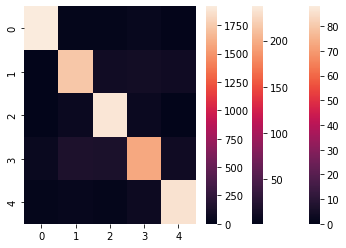



########## Test Data Accuracy ######### 


              precision    recall  f1-score   support

           0       0.79      0.80      0.80       100
           1       0.71      0.57      0.63       100
           2       0.68      0.88      0.77       100
           3       0.50      0.43      0.46       100
           4       0.81      0.83      0.82       100

    accuracy                           0.70       500
   macro avg       0.70      0.70      0.69       500
weighted avg       0.70      0.70      0.69       500



########## Valid Data Accuracy ######### 


              precision    recall  f1-score   support

           0       0.80      0.79      0.79       300
           1       0.49      0.53      0.51       300
           2       0.65      0.71      0.68       300
           3       0.41      0.38      0.40       300
           4       0.79      0.72      0.75       300

    accuracy                           0.63      1500
   macro avg       0.63      0.63      0

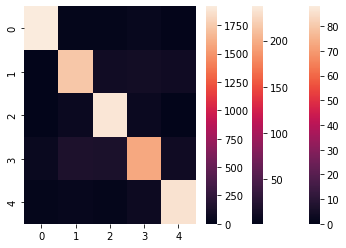



########## Test Data Accuracy ######### 


              precision    recall  f1-score   support

           0       0.79      0.80      0.80       100
           1       0.71      0.57      0.63       100
           2       0.68      0.88      0.77       100
           3       0.50      0.43      0.46       100
           4       0.81      0.83      0.82       100

    accuracy                           0.70       500
   macro avg       0.70      0.70      0.69       500
weighted avg       0.70      0.70      0.69       500



########## Valid Data Accuracy ######### 


              precision    recall  f1-score   support

           0       0.80      0.79      0.79       300
           1       0.49      0.53      0.51       300
           2       0.65      0.71      0.68       300
           3       0.41      0.38      0.40       300
           4       0.79      0.72      0.75       300

    accuracy                           0.63      1500
   macro avg       0.63      0.63      0

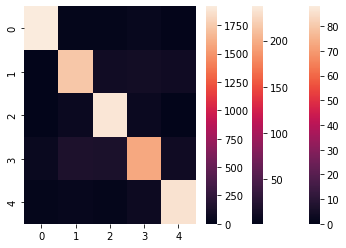



########## Test Data Accuracy ######### 


              precision    recall  f1-score   support

           0       0.79      0.80      0.80       100
           1       0.71      0.57      0.63       100
           2       0.68      0.88      0.77       100
           3       0.50      0.43      0.46       100
           4       0.81      0.83      0.82       100

    accuracy                           0.70       500
   macro avg       0.70      0.70      0.69       500
weighted avg       0.70      0.70      0.69       500



########## Valid Data Accuracy ######### 


              precision    recall  f1-score   support

           0       0.80      0.79      0.79       300
           1       0.49      0.53      0.51       300
           2       0.65      0.71      0.68       300
           3       0.41      0.38      0.40       300
           4       0.79      0.72      0.75       300

    accuracy                           0.63      1500
   macro avg       0.63      0.63      0

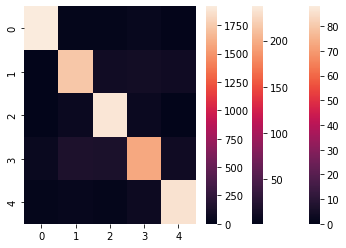



########## Test Data Accuracy ######### 


              precision    recall  f1-score   support

           0       0.79      0.80      0.80       100
           1       0.71      0.57      0.63       100
           2       0.68      0.88      0.77       100
           3       0.50      0.43      0.46       100
           4       0.81      0.83      0.82       100

    accuracy                           0.70       500
   macro avg       0.70      0.70      0.69       500
weighted avg       0.70      0.70      0.69       500



########## Valid Data Accuracy ######### 


              precision    recall  f1-score   support

           0       0.80      0.79      0.79       300
           1       0.49      0.53      0.51       300
           2       0.65      0.71      0.68       300
           3       0.41      0.38      0.40       300
           4       0.79      0.72      0.75       300

    accuracy                           0.63      1500
   macro avg       0.63      0.63      0

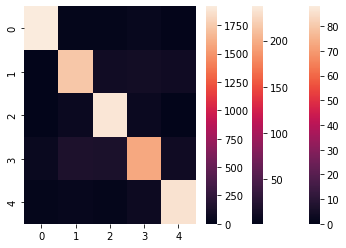



########## Test Data Accuracy ######### 


              precision    recall  f1-score   support

           0       0.79      0.80      0.80       100
           1       0.71      0.57      0.63       100
           2       0.68      0.88      0.77       100
           3       0.50      0.43      0.46       100
           4       0.81      0.83      0.82       100

    accuracy                           0.70       500
   macro avg       0.70      0.70      0.69       500
weighted avg       0.70      0.70      0.69       500



########## Valid Data Accuracy ######### 


              precision    recall  f1-score   support

           0       0.80      0.79      0.79       300
           1       0.49      0.53      0.51       300
           2       0.65      0.71      0.68       300
           3       0.41      0.38      0.40       300
           4       0.79      0.72      0.75       300

    accuracy                           0.63      1500
   macro avg       0.63      0.63      0

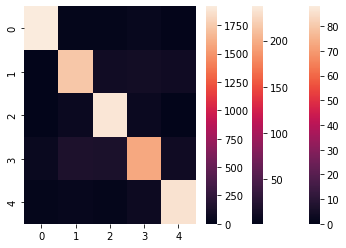



########## Test Data Accuracy ######### 


              precision    recall  f1-score   support

           0       0.79      0.80      0.80       100
           1       0.71      0.57      0.63       100
           2       0.68      0.88      0.77       100
           3       0.50      0.43      0.46       100
           4       0.81      0.83      0.82       100

    accuracy                           0.70       500
   macro avg       0.70      0.70      0.69       500
weighted avg       0.70      0.70      0.69       500



########## Valid Data Accuracy ######### 


              precision    recall  f1-score   support

           0       0.80      0.79      0.79       300
           1       0.49      0.53      0.51       300
           2       0.65      0.71      0.68       300
           3       0.41      0.38      0.40       300
           4       0.79      0.72      0.75       300

    accuracy                           0.63      1500
   macro avg       0.63      0.63      0

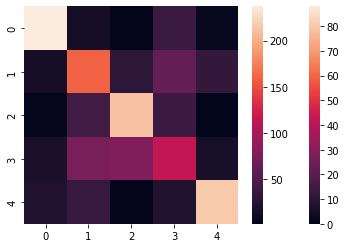

In [113]:
test_acc,train_acc,valid_acc= [],[],[]
for epoch in range(epochs):
    print("############# epoch {} ############".format(epoch+1))
    
    train_acc_score, test_acc_score,valid_acc_score = accuracy(train_loader,test_loader,valid_loader,models[epoch]['model'],reshape=False)
    train_acc.append(train_acc_score)
    test_acc.append(test_acc_score)
    valid_acc.append(valid_acc_score)


    

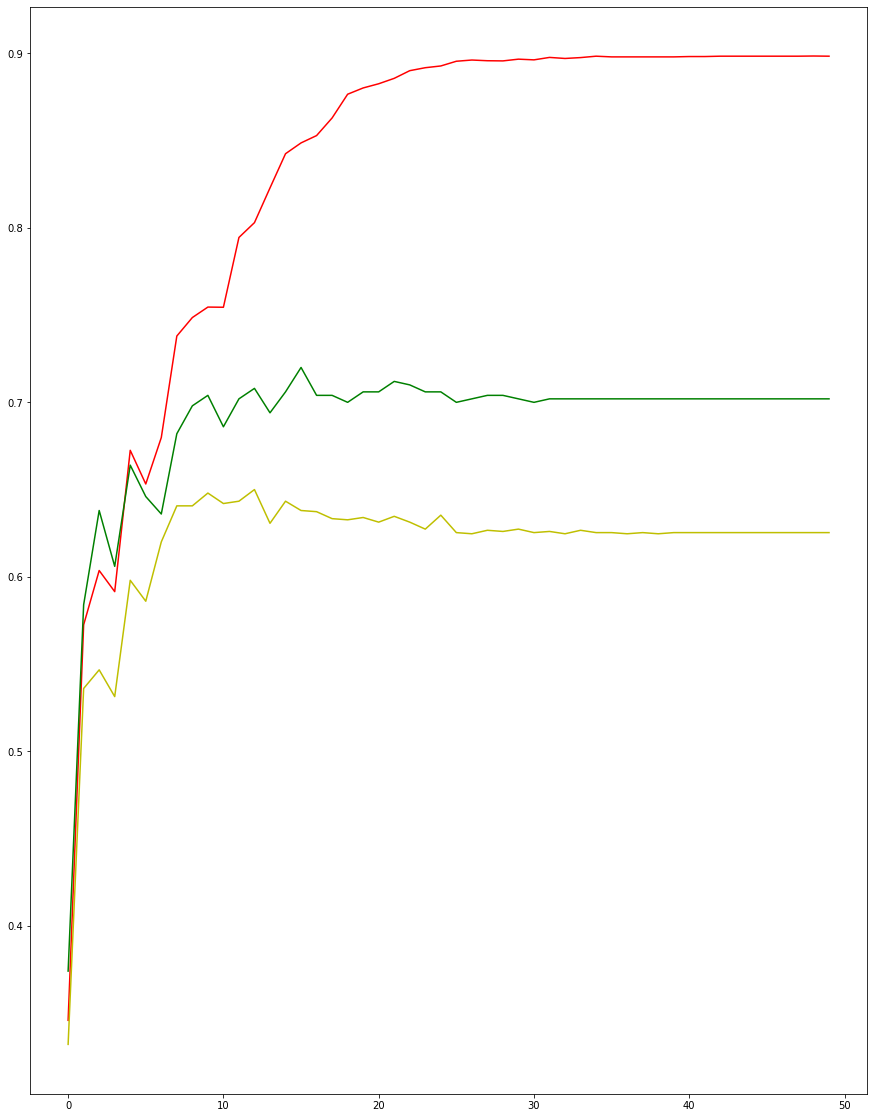

In [114]:
fig = plt.figure(figsize=(15,20))
plt.plot(range(epochs),train_acc,'-r')
plt.plot(range(epochs),test_acc,'-g')
plt.plot(range(epochs),valid_acc,'-y')

In [115]:
for epoch in range(epochs):
    print(f'Epoch: {epoch}\n \
    Validation Accracy: {valid_acc[epoch]}\n \
    test Accracy: {test_acc[epoch]}\n \
    train Accracy: {train_acc[epoch]}')

Epoch: 0
     Validation Accracy: 0.332
     test Accracy: 0.374
     train Accracy: 0.3458
Epoch: 1
     Validation Accracy: 0.536
     test Accracy: 0.584
     train Accracy: 0.5725
Epoch: 2
     Validation Accracy: 0.5466666666666666
     test Accracy: 0.638
     train Accracy: 0.6036
Epoch: 3
     Validation Accracy: 0.5313333333333333
     test Accracy: 0.606
     train Accracy: 0.5915
Epoch: 4
     Validation Accracy: 0.598
     test Accracy: 0.664
     train Accracy: 0.6725
Epoch: 5
     Validation Accracy: 0.586
     test Accracy: 0.646
     train Accracy: 0.6532
Epoch: 6
     Validation Accracy: 0.62
     test Accracy: 0.636
     train Accracy: 0.6798
Epoch: 7
     Validation Accracy: 0.6406666666666667
     test Accracy: 0.682
     train Accracy: 0.738
Epoch: 8
     Validation Accracy: 0.6406666666666667
     test Accracy: 0.698
     train Accracy: 0.7486
Epoch: 9
     Validation Accracy: 0.648
     test Accracy: 0.704
     train Accracy: 0.7546
Epoch: 10
     Validation Accr